In [76]:
import json
import matplotlib.pyplot as plt
import os, traceback
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score, matthews_corrcoef
import argparse
import sys
sys.path.insert(0, '/home/guillaumeleclerc/julian/OPSUM/')


from prediction.outcome_prediction.LSTM.training.utils import initiate_log_files
from prediction.outcome_prediction.data_loading.data_formatting import format_to_2d_table_with_time, \
    link_patient_id_to_outcome, features_to_numpy, numpy_to_lookup_table, feature_order_verification
from prediction.utils.scoring import precision, matthews, recall
from prediction.utils.utils import generate_balanced_arrays, check_data, ensure_dir, save_json
from prediction.outcome_prediction.LSTM.LSTM import lstm_generator


def prep(features_path: str, labels_path:str, outcome:str, test_size:float,seed=0, n_splits=7):
    ### LOAD THE DATA
    X, y = format_to_2d_table_with_time(feature_df_path=features_path, outcome_df_path=labels_path,
                                        outcome=outcome)

    n_time_steps = X.relative_sample_date_hourly_cat.max() + 1
    n_channels = X.sample_label.unique().shape[0]

    # test if data is corrupted
    check_data(X)

    """
    SPLITTING DATA
    Splitting is done by patient id (and not admission id) as in case of the rare multiple admissions per patient there
    would be a risk of data leakage otherwise split 'pid' in TRAIN and TEST pid = unique patient_id
    """
    # Reduce every patient to a single outcome (to avoid duplicates)
    all_pids_with_outcome = link_patient_id_to_outcome(y, outcome)
    pid_train, pid_test, y_pid_train, y_pid_test = train_test_split(all_pids_with_outcome.patient_id.tolist(),
                                                                    all_pids_with_outcome.outcome.tolist(),
                                                                    stratify=all_pids_with_outcome.outcome.tolist(),
                                                                    test_size=test_size,
                                                                    random_state=seed)

    test_X = X[X.patient_id.isin(pid_test)]
    # Here test data is not needed anymore, but for reference should be loaded as such: test_y = y[y.patient_id.isin(pid_test)]

    # define K fold
    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)

    
    ### TRAIN MODEL USING K-FOLD CROSS-VALIDATION
    i = 0
    for fold_pid_train_idx, fold_pid_val_idx in kfold.split(pid_train, y_pid_train):
        fold_train_pidx = np.array(pid_train)[fold_pid_train_idx]
        fold_val_pidx = np.array(pid_train)[fold_pid_val_idx]

        fold_X_train_df = X.loc[X.patient_id.isin(fold_train_pidx)]
        fold_y_train_df = y.loc[y.patient_id.isin(fold_train_pidx)]
        fold_X_val_df = X.loc[X.patient_id.isin(fold_val_pidx)]
        fold_y_val_df = y.loc[y.patient_id.isin(fold_val_pidx)]

        fold_X_train = features_to_numpy(fold_X_train_df, ['case_admission_id', 'relative_sample_date_hourly_cat', 'sample_label', 'value'])
        fold_X_val = features_to_numpy(fold_X_val_df, ['case_admission_id', 'relative_sample_date_hourly_cat', 'sample_label', 'value'])

        fold_y_train = np.array([fold_y_train_df[fold_y_train_df.case_admission_id == cid].outcome.values[0] for cid in fold_X_train[:, 0, 0, 0]]).astype('float32')
        fold_y_val = np.array([fold_y_val_df[fold_y_val_df.case_admission_id == cid].outcome.values[0] for cid in fold_X_val[:, 0, 0, 0]]).astype('float32')

        fold_X_train = fold_X_train[:, :, :, -1].astype('float32')
        fold_X_val = fold_X_val[:, :, :, -1].astype('float32')
        
        return fold_X_train, fold_X_val, fold_y_train, fold_y_val


In [18]:
X_train.shape


(1345, 72, 84)

In [179]:
X_train, X_val , y_train, y_val = prep('/home/guillaumeleclerc/julian/preprocessed_features_01012023_233050.csv', '/home/guillaumeleclerc/julian/preprocessed_outcomes_01012023_233050.csv', outcome="3M mRS 0-2",
    test_size=0.3, seed=5)

Found 247 case_admission_ids with no outcome. These will be excluded.


/home/guillaumeleclerc/julian/OPSUM/prediction/outcome_prediction/data_loading/data_formatting.py:125: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_pids_no_duplicates = all_pids_no_duplicates.append(reduced_pids)


In [189]:
def prep_average(features, labels):
    avg_features = np.cumsum(features, 1) / (np.arange(1, features.shape[1] + 1)[None, :, None])
    min_features = np.minimum.accumulate(features, 1)
    max_features = np.maximum.accumulate(features, 1)
    all_features = np.concatenate([features, avg_features, min_features, max_features], 2)
    all_features = all_features.reshape(-1, all_features.shape[-1])
    labels = labels[:, None].repeat(72, 1).ravel()
    print(labels.shape)
    return all_features, labels

In [366]:
classifier = XGBClassifier(n_estimators=65, learning_rate=0.1, reg_lambda=50, alpha=70)

In [367]:
flat_features_train, flat_labels_train = prep_average(X_train, y_train)
flat_features_val, flat_labels_val = prep_average(X_val, y_val)

(97200,)
(16200,)


In [373]:
%time classifier.fit(flat_features_train, flat_labels_train)

CPU times: user 5min, sys: 3.97 s, total: 5min 4s
Wall time: 26.4 s


XGBClassifier(alpha=70, base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=65, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=70, ...)

In [369]:
prediction_train = classifier.predict_proba(flat_features_train)[:, 1].reshape(-1, 72).T
prediction_val = classifier.predict_proba(flat_features_val)[:, 1].reshape(-1, 72).T
scores_train = []
scores_val = []
for time in range(72):
    scores_train.append(roc_auc_score(y_train, prediction_train[time]))
    scores_val.append(roc_auc_score(y_val, prediction_val[time]))

In [370]:
roc_auc_score(flat_labels_val, prediction_val.T.ravel())

0.8958929580729563

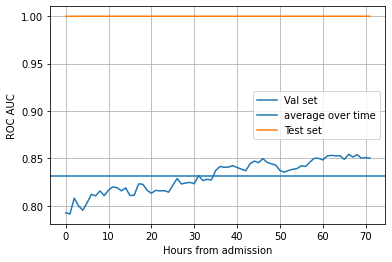

In [407]:
plt.plot(scores_val, label='Val set')
plt.gca().set_ylabel('ROC AUC')
plt.xlabel('Hours from admission')
plt.axhline(roc_auc_score(flat_labels_val, prediction_val.T.ravel()), label='average over time')
plt.plot(scores_train, label='Test set')
plt.grid()
plt.legend()

In [375]:
from sklearn.metrics import roc_curve

In [ ]:
roc_auc_score

In [507]:
a, b, c  = roc_curve(flat_labels_val, prediction_val.T.ravel())

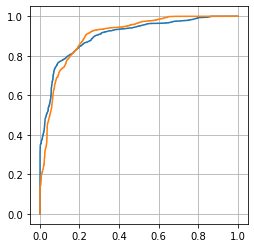

In [508]:
plt.plot(a, b)
plt.plot(1 - b, 1 - a)
plt.grid()
plt.gca().set_aspect('equal')

In [398]:
from sklearn.neural_network import MLPClassifier

In [501]:
model2 = MLPClassifier((128, 128, 64), learning_rate='adaptive', alpha=12.5)

In [502]:
%time model2.fit(flat_features_train, flat_labels_train)

CPU times: user 11min 43s, sys: 9.37 s, total: 11min 53s
Wall time: 1min 29s


MLPClassifier(alpha=12.5, hidden_layer_sizes=(128, 128, 64),
              learning_rate='adaptive')

In [503]:
prediction_train = model2.predict_proba(flat_features_train)[:, 1].reshape(-1, 72).T
prediction_val = model2.predict_proba(flat_features_val)[:, 1].reshape(-1, 72).T
scores_train = []
scores_val = []
for time in range(72):
    scores_train.append(roc_auc_score(y_train, prediction_train[time]))
    scores_val.append(roc_auc_score(y_val, prediction_val[time]))

In [504]:
roc_auc_score(flat_labels_val, prediction_val.T.ravel())

0.903509818117157

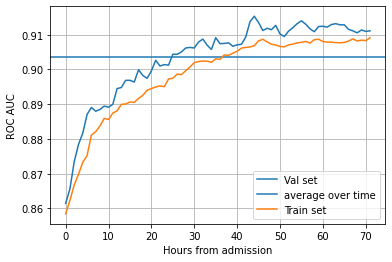

In [505]:
plt.plot(scores_val, label='Val set')
plt.gca().set_ylabel('ROC AUC')
plt.xlabel('Hours from admission')
plt.axhline(roc_auc_score(flat_labels_val, prediction_val.T.ravel()), label='average over time')
plt.plot(scores_train, label='Train set')
plt.grid()
plt.legend()